In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib

In [2]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('../../data/processed/기아_차종별판매실적_전처리.CSV')
df.replace("-", 0, inplace=True)

# 쉼표 제거 및 숫자형 변환
month_cols = ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월']
df[month_cols] = df[month_cols].apply(lambda x: x.astype(str).str.replace(',', '').astype(float))

def prepare_time_series(df, model_name, region_type):
    sub_df = df[(df['차종'] == model_name) & (df['거래 유형'] == region_type)]
    
    if sub_df.empty:
        raise ValueError(f"[{model_name}] - [{region_type}] 데이터 없음")

    # melt: wide → long 형태로 변환
    df_melted = sub_df.melt(id_vars=['연도'], value_vars=month_cols,
                            var_name='월', value_name='판매량')

    # 월 문자열 처리 → 숫자로 변환
    df_melted['월'] = df_melted['월'].str.replace('월', '').astype(int)

    # 날짜 열 만들기
    df_melted['ds'] = pd.to_datetime(dict(year=df_melted['연도'], month=df_melted['월'], day=1))
    df_melted = df_melted.sort_values('ds')
    df_melted = df_melted[['ds', '판매량']].rename(columns={'판매량': 'y'})
    
    return df_melted

def predict_sales(df, model_name, region_type, n_months):
    ts_df = prepare_time_series(df, model_name, region_type)

    ts_df['floor'] = 0
    model = Prophet()
    model.fit(ts_df)

    future = model.make_future_dataframe(periods=n_months, freq='MS')
    future['floor'] = 0

    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 0))

    # 시각화
    model.plot(forecast)
    plt.title(f"{model_name} [{region_type}] 판매량 예측")
    plt.tight_layout()
    plt.show()

    # 결과 출력
    future_pred = forecast[['ds', 'yhat']].tail(n_months)
    print(f"\n🔮 [{model_name}] - [{region_type}] 예측 결과:")
    for _, row in future_pred.iterrows():
        print(f"{row['ds'].strftime('%Y-%m')} 예측 판매량: {row['yhat']:.2f}")

17:49:36 - cmdstanpy - INFO - Chain [1] start processing


17:49:36 - cmdstanpy - INFO - Chain [1] done processing


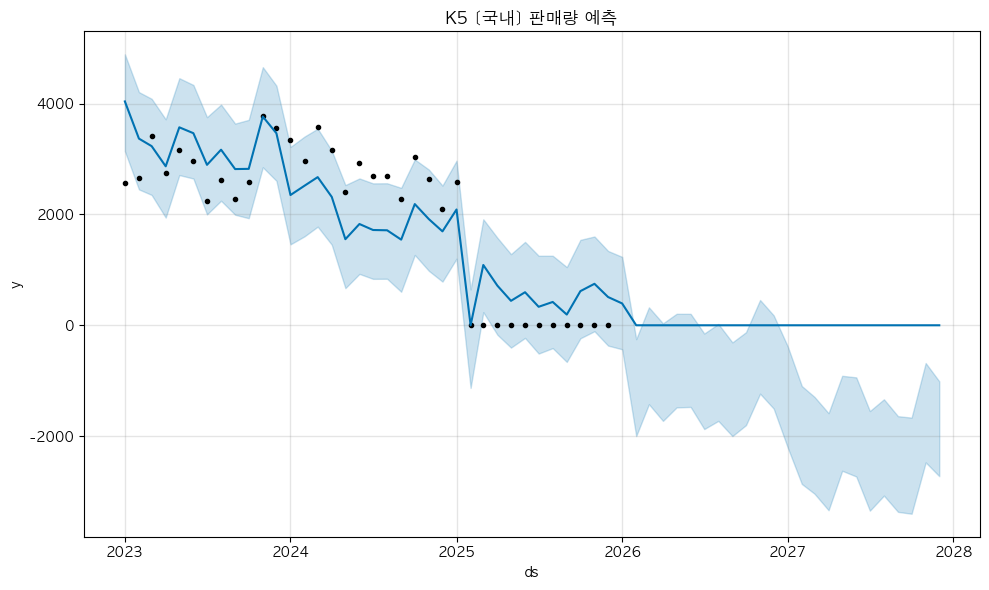

17:49:36 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing



🔮 [K5] - [국내] 예측 결과:
2026-01 예측 판매량: 393.99
2026-02 예측 판매량: 0.00
2026-03 예측 판매량: 0.00
2026-04 예측 판매량: 0.00
2026-05 예측 판매량: 0.00
2026-06 예측 판매량: 0.00
2026-07 예측 판매량: 0.00
2026-08 예측 판매량: 0.00
2026-09 예측 판매량: 0.00
2026-10 예측 판매량: 0.00
2026-11 예측 판매량: 0.00
2026-12 예측 판매량: 0.00
2027-01 예측 판매량: 0.00
2027-02 예측 판매량: 0.00
2027-03 예측 판매량: 0.00
2027-04 예측 판매량: 0.00
2027-05 예측 판매량: 0.00
2027-06 예측 판매량: 0.00
2027-07 예측 판매량: 0.00
2027-08 예측 판매량: 0.00
2027-09 예측 판매량: 0.00
2027-10 예측 판매량: 0.00
2027-11 예측 판매량: 0.00
2027-12 예측 판매량: 0.00


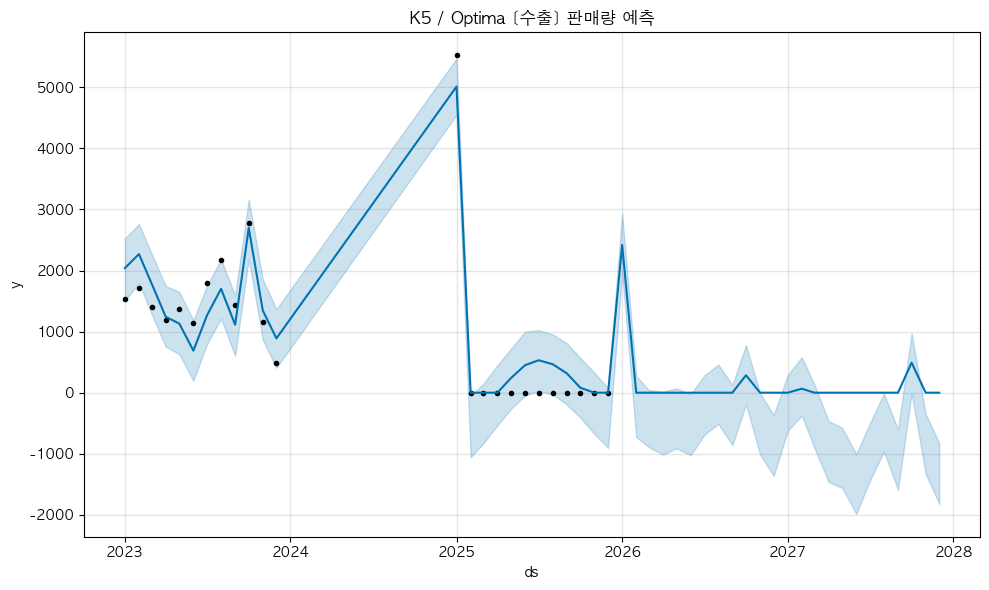


🔮 [K5 / Optima] - [수출] 예측 결과:
2026-01 예측 판매량: 2417.95
2026-02 예측 판매량: 0.00
2026-03 예측 판매량: 0.00
2026-04 예측 판매량: 0.00
2026-05 예측 판매량: 0.00
2026-06 예측 판매량: 0.00
2026-07 예측 판매량: 0.00
2026-08 예측 판매량: 0.00
2026-09 예측 판매량: 0.00
2026-10 예측 판매량: 285.64
2026-11 예측 판매량: 0.00
2026-12 예측 판매량: 0.00
2027-01 예측 판매량: 0.00
2027-02 예측 판매량: 65.41
2027-03 예측 판매량: 0.00
2027-04 예측 판매량: 0.00
2027-05 예측 판매량: 0.00
2027-06 예측 판매량: 0.00
2027-07 예측 판매량: 0.00
2027-08 예측 판매량: 0.00
2027-09 예측 판매량: 0.00
2027-10 예측 판매량: 492.49
2027-11 예측 판매량: 0.00
2027-12 예측 판매량: 0.00


In [46]:
predict_sales(df, model_name="K5", region_type="국내", n_months=24)
predict_sales(df, model_name="K5 / Optima", region_type="수출", n_months=24)